# Untitled Notebook

What's this notebook about?

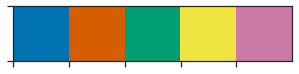

In [2]:
import sys
import re
import os
from glob import glob
import random
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import seaborn as sns

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [3]:
def get_gtf_attribute(gtf_record, attribute):
    try:
        attr = re.search(f'{attribute} "(.+?)";', gtf_record[8]).group(1)
    except AttributeError:
        raise ValueError(
            f'Could not parse attribute {attribute} '
            f'from GTF with feature type {record[2]}'
        )
    return attr


locus2gene = defaultdict(set)
with open('../../nanopore_apa_pipeline/pipeline/assembly/merged_nanopore_assembly.gtf') as gtf:
    for record in gtf:
        record = record.split('\t')
        if record[2] == 'transcript':
            locus_id = get_gtf_attribute(record, 'locus')
            gene_id = get_gtf_attribute(record, 'gene_id')
            if re.match('AT[1-5]G\d{5}', gene_id):
                locus2gene[locus_id].add(gene_id)

locus2gene = {k: ','.join(v) for k, v in locus2gene.items()}

In [4]:
RESULTS_COLUMNS = [
    'chrom', 'start', 'end', 'locus_id', 'score', 'strand',
    'wass_dist', 'wass_dir', 'wass_pval', 'wass_fdr',
    'nreads_cntrl', 'nreads_treat'
]

fpa_vs_col0 = pd.read_csv(
    '../pipeline/apa_results/fpa8_vs_col0.apa_results.bed',
    sep='\t',
    names=RESULTS_COLUMNS
)
fpa_vs_col0['gene_ids'] = fpa_vs_col0.locus_id.map(locus2gene)

FPAox_vs_col0 = pd.read_csv(
    '../pipeline/apa_results/35SFPA_vs_col0.apa_results.bed',
    sep='\t',
    names=RESULTS_COLUMNS
)
FPAox_vs_col0['gene_ids'] = FPAox_vs_col0.locus_id.map(locus2gene)

FPAox_vs_col0.head()

,chrom,start,end,locus_id,score,strand,wass_dist,wass_dir,wass_pval,wass_fdr,nreads_cntrl,nreads_treat,gene_ids
0,1,5885,13714,RLOC_00000002,384,-,383.6,-382.9,0.1620,0.446,66,89,"AT1G01020,AT1G01030"
1,1,31115,33315,RLOC_00000006,13,-,13.2,13.1,0.1180,0.390,208,324,AT1G01050
2,1,33364,37871,RLOC_00000008,25,-,24.8,-4.5,0.0988,0.363,189,336,AT1G01060
3,1,44797,49306,RLOC_00000011,26,-,26.2,-16.4,0.6110,0.823,774,953,AT1G01080
4,1,49908,51210,RLOC_00000012,4,-,3.7,2.0,0.1260,0.400,2226,2866,AT1G01100


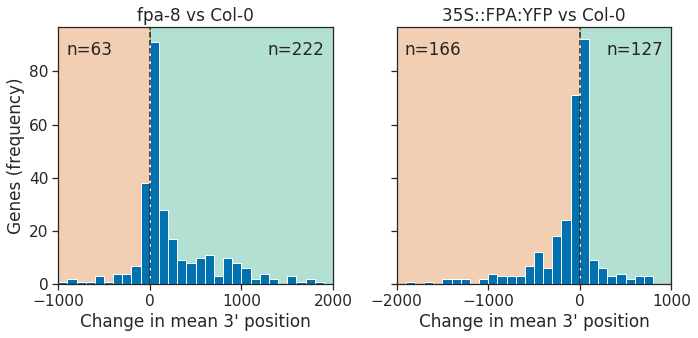

In [5]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)

ax_it = zip(
    axes,
    [fpa_vs_col0, FPAox_vs_col0],
    [-1000, -2000],
    [2000, 1000],
    ['fpa-8 vs Col-0', '35S::FPA:YFP vs Col-0'],
)

for ax, df, lower_bound, upper_bound, title in ax_it:
    sig = df.query('wass_fdr < 0.05 & wass_dist > 25')
    ax.hist(sig.wass_dir, bins=30, range=(lower_bound, upper_bound))
    ax.axvline(0, ls='--', color='#252525')
    ax.axvspan(lower_bound, 0, color=pal[1], zorder=0, alpha=0.3)
    ax.axvspan(0, upper_bound, color=pal[2], zorder=0, alpha=0.3)
    ax.set_xlim(lower_bound, upper_bound)

    n_prox = len(sig.query('wass_dir < 0'))
    n_dist = len(sig.query('wass_dir > 0'))

    ax.annotate(
        xy=(0.03, 0.89),
        s=f'n={n_prox}',
        xycoords='axes fraction'
    )
    ax.annotate(
        xy=(0.97, 0.89),
        s=f'n={n_dist}',
        ha='right',
        xycoords='axes fraction',
    )
    ax.set_xlabel('Change in mean 3\' position')
    ax.set_ylabel('')
    ax.set_title(title)
axes[0].set_ylabel('Genes (frequency)')
plt.tight_layout()
plt.savefig('figures/nanopore_fpa_35FPA_APA.svg')
plt.show()

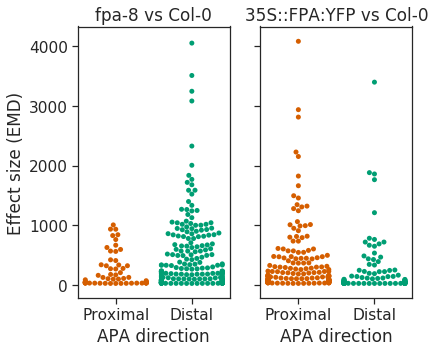

In [6]:
fig, axes = plt.subplots(figsize=(6, 5), ncols=2, sharey=True)

sns.swarmplot(
    x=fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dir > 0,
    y=fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dist,
    ax=axes[0],
    palette=pal[1:3]
)

sns.swarmplot(
    x=FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dir > 0,
    y=FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').wass_dist,
    ax=axes[1],
    palette=pal[1:3]
)
axes[0].set_title('fpa-8 vs Col-0')
axes[1].set_title('35S::FPA:YFP vs Col-0')
#axes[0].set_ylim(-50, 1100)
axes[0].set_ylabel('Effect size (EMD)')
axes[1].set_ylabel('')
axes[0].set_xticklabels(['Proximal', 'Distal'])
axes[1].set_xticklabels(['Proximal', 'Distal'])
axes[0].set_xlabel('APA direction')
axes[1].set_xlabel('APA direction')
plt.savefig('figures/nanopore_fpa_35FPA_APA_effect_size.svg')
plt.show()

In [7]:
genes_tested_in_both = set(fpa_vs_col0.locus_id).intersection(FPAox_vs_col0.locus_id)
fpa_distal = set(fpa_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir > 0').locus_id)
FPAox_proximal = set(FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25 & wass_dir < 0').locus_id)

print(
    len(fpa_distal.intersection(FPAox_proximal)) - 1,
    len(genes_tested_in_both),
    len(fpa_distal.intersection(genes_tested_in_both)),
    len(FPAox_proximal.intersection(genes_tested_in_both)),
)

stats.hypergeom.sf(
    len(fpa_distal.intersection(FPAox_proximal)) - 1,
    len(genes_tested_in_both),
    len(fpa_distal.intersection(genes_tested_in_both)),
    len(FPAox_proximal.intersection(genes_tested_in_both)),
)

15 9715 215 158


3.8836001200505515e-07